In [370]:
import numpy as np

import librosa
import librosa.display

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.nn.functional as F
import torchaudio
from IPython.display import Audio
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm

In [185]:
def process_waveform(waveform, max_waveform_length):
    # Pad or truncate waveform to max_waveform_length
    waveform_length = waveform.size(1)
    if waveform_length < max_waveform_length:
        padding = torch.zeros(1, max_waveform_length - waveform_length)
        waveform = torch.cat([waveform, padding], dim=1)
    elif waveform_length > max_waveform_length:
        waveform = waveform[:, :max_waveform_length]
    return waveform

In [207]:
# n_fft = size of window to sample the input 
# hop_length = # of samples between successive STFT frames
# n_mels = separates entire freq spectrum into n_mels greq bins

def process_spec(max_spec_len, waveform, sr):
    mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=80, n_fft=400, hop_length=160)
    spectrogram = mel_spec_transform(waveform)
    # Pad or truncate spectrogram to max_spec_len
    spec_len = spectrogram.size(2)
    if spec_len < max_spec_len:
        padding = torch.zeros(1, 80, max_spec_len - spec_len)  # Add a new axis
        spectrogram = torch.cat([spectrogram, padding], dim=2)

    elif spec_len > max_spec_len:
        spectrogram = spectrogram[:, :, :max_spec_len]

    epsilon = 1e-10
    spec_db = 10 * torch.log10(spectrogram + epsilon)

    return spec_db

In [335]:
emotion_to_number = {'NEU': 0, 'HAP': 1, 'SAD': 2, 'ANG': 3, 'DIS': 4, 'FEA': 5}
number_to_emotion = {0: 'NEU', 1: 'HAP', 2: 'SAD', 3: 'ANG', 4: 'DIS', 5: 'FEA'}
def get_label(type, filename):
    if(type == 'crema_d'):
        return filename.split('_')[2]

def load_dataset(directory, type, max_waveform_length, max_spec_len):
    dataset = []
    raw_dataset = []
    
    # Iterate through files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            
            filepath = os.path.join(directory, filename)
            emotion = get_label(type,filename)
            emotion_no = emotion_to_number[emotion]
            emotion_label = torch.zeros(6)
            emotion_label[emotion_no] = 1
            raw_dataset.append([filepath, emotion_label])
            
            # Load audio waveform
            waveform, sr = torchaudio.load(filepath)
            waveform = process_waveform(waveform, max_waveform_length)
            
            # Compute spectrogram
            spectrogram = process_spec(max_spec_len=max_spec_len, waveform=waveform, sr=sr)
            
            dataset.append((spectrogram, emotion_label))

    return dataset, raw_dataset


def split_dataset(dataset, batch_size, train_ratio=0.9):

    # Split dataset into training and testing sets
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader objects for training and testing sets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataset, test_dataset, train_dataloader, test_dataloader

In [209]:
crema_d_path = './AudioWAV'

dataset, raw_dataset = load_dataset(crema_d_path, 'crema_d', 80080, 500)
train_dataset, test_dataset, train_dataloader, test_dataloader = split_dataset(dataset, 32)

print(len(dataset))

7442


In [210]:
print(len(dataset))
for batch_idx, (s, l) in enumerate(train_dataloader):
    print(s.size())
    print(l.size())
    break


7442
torch.Size([32, 1, 80, 500])
torch.Size([32, 6])


In [323]:
class RNN(nn.Module):
   def __init__(self, input_size, hidden_size, num_layers, num_classes):
      super(RNN, self).__init__()
      self.hidden_size = hidden_size
      self.num_layers = num_layers
      self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
      self.fc = nn.Linear(hidden_size, num_classes)
      self.softmax = nn.Softmax(dim=1)  # Add softmax layer
   
   def forward(self, x):
      # Flatten the spectrogram data along the frequency_bins dimension
      x = x.view(x.size(0), -1, x.size(3))  # [batch_size, channels * frequency_bins, time_steps]
      x = torch.permute(x,(0,2,1))
      
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
      c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
      out, _ = self.lstm(x, (h0, c0))  
      # Only take the output from the last time step
      out = self.fc(out[:, -1, :])  # [batch_size, num_classes]
      out = self.softmax(out)  # Apply softmax activation
      return out

In [262]:
def training(model, loss_function, optimizer, train_dataloader, n_epochs, update_interval):
    # model.train()
    losses = []

    for n in range(n_epochs):
        for i, (specgram, label) in enumerate(tqdm(iter(train_dataloader))):
            specgram, label = specgram.cuda(), label.cuda()
            optimizer.zero_grad()
            pred = model(specgram)
            loss = loss_function(pred, label) #err incompatible tensoor dimensions
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

            if i % update_interval == 0:
                losses.append(round(loss.item(), 2)) # This will append your losses for plotting -- please use "loss" as the name for your loss
        
    return model, losses

100%|██████████| 210/210 [00:03<00:00, 54.84it/s]


avg loss: 1.6460313804964999


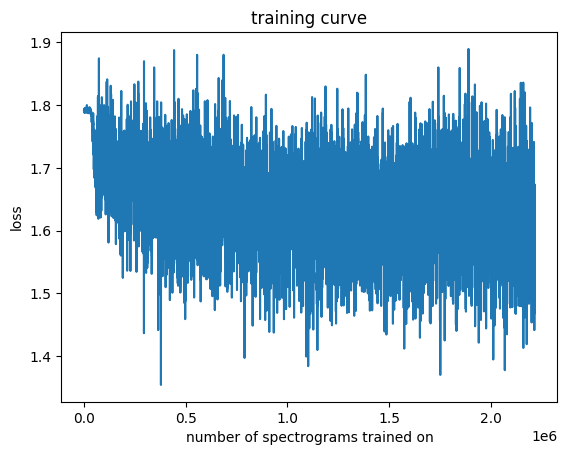

In [371]:
batch_size = 32
lr = 1e-4
n_epochs= 30
update_interval=10

input_size = 80  # input size after flattening the spectrogram
hidden_size = 100  # size of the hidden state
num_layers = 4  # number of LSTM layers
num_classes = 6  # number of output classes


train_dataset, test_dataset, train_dataloader, test_dataloader = split_dataset(dataset, batch_size)

# Initialize the LSTM model
model = RNN(input_size, hidden_size, num_layers, num_classes)
model.cuda()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

trained_model, losses = training(model, loss_function, optimizer, train_dataloader, n_epochs=n_epochs, update_interval=update_interval)

print("avg loss:", sum(losses)/len(losses))

plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses)
plt.title("training curve")
plt.xlabel("number of spectrograms trained on")
plt.ylabel("loss")
plt.show()

In [331]:
def test_accuracy(model, loss_function, test_data):
    sum_loss = 0
    n_correct = 0
    total = 0

    for i, (spec, label) in enumerate(tqdm(iter(test_data))):
        spec,label = spec.cuda(), label.cuda()
        pred = model(spec)
        loss = loss_function(pred, label)
        sum_loss += loss.item()

        _, predicted = torch.max(pred,1)
        _, label = torch.max(label,1)
        n_correct += (predicted == label).sum()
        total += label.size(0)
    
    test_acc = round(((n_correct / total).item() * 100), 2)
    avg_loss = round(sum_loss / len(test_data), 2)

    print("Test Accuracy:", test_acc)
    print("Test Loss:", avg_loss )

    return test_acc, avg_loss

In [372]:
test_acc,avg_loss = test_accuracy(trained_model, loss_function, test_dataloader)

print("Test Accuracy:", test_acc)
print("Average Loss:", avg_loss)

100%|██████████| 24/24 [00:00<00:00, 38.87it/s]

Test Accuracy: 40.27
Test Loss: 1.64
Test Accuracy: 40.27
Average Loss: 1.64


### Live Demo!

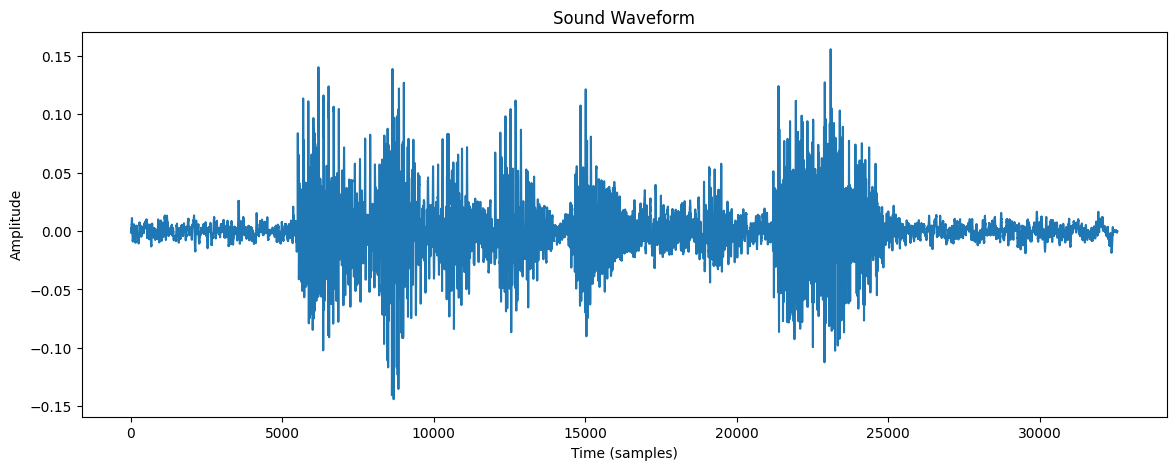

In [382]:
#Choose a random sample and visualize the data
ex_audio, ex_label = raw_dataset[random.randint(0,len(raw_dataset))]
y, sr = librosa.load(ex_audio, sr=None)

#Visualize sound wave
plt.figure(figsize=(14, 5))
plt.plot(y)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Sound Waveform')
plt.show()

#Play the audio sample!
Audio(data=y, rate=sr)

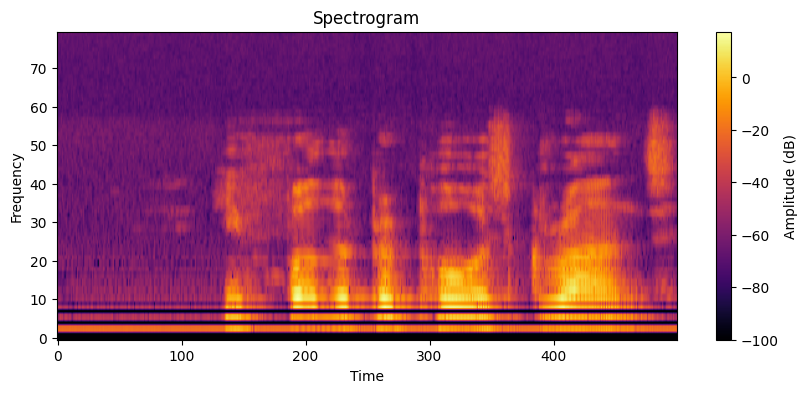

In [383]:
waveform, sr = torchaudio.load(filepath)
waveform = process_waveform(waveform, 80080)
spectrogram = process_spec(max_spec_len=500, waveform=waveform, sr=sr)
spectrogram_np = spectrogram.numpy()

# Display spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram_np[0], aspect='auto', origin='lower', cmap='inferno')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram')
plt.colorbar(label='Amplitude (dB)')
plt.show()

In [384]:
spectrogram = spectrogram.unsqueeze(0)
spectrogram = spectrogram.cuda()
prediction = trained_model(spectrogram)

#Convert probabilities to reflect highest probability label
pred = torch.zeros_like(prediction)
pred[0, torch.argmax(prediction)] = 1
pred = pred.cpu().squeeze()

print("Prediction:", pred, "which is", number_to_emotion[torch.argmax(pred).item()])
print("Actual:", ex_label, 'which is', number_to_emotion[torch.argmax(ex_label).item()])

Prediction: tensor([1., 0., 0., 0., 0., 0.]) which is NEU
Actual: tensor([1., 0., 0., 0., 0., 0.]) which is NEU
